# SNR and Q factor anaysis of a simple optical communications link

 This notebook attempts to reproduce an exercise on noise contribution sources at an optical PHY. The exercise in question was proposed by Robert Dahlgren (Bob.Dahlgren@ieee.org) in a document about [noise in fiber optic communication links](http://www.svphotonics.com/pub/pub029.pdf). 

The optical PHY in question consists of the elements in the following diagram:

<img src="img/optical_PHY.png">

The transmitted signal travels from left to right and passes through stages where its subject to amplification, conversion and noise addition. Multiplicative scale factors denoted by the greek letter $\eta$ represent stages where the signal and noise are either amplified and or converted from E/O or O/E stages. Noise sources are assumed to be Gaussian and their standard deviation is denoted by the greek letter $\sigma$.

Optical PHY glossary:
- LDD: Laser Diode Driver
- $\sigma_{TX}$: Standard deviation of electrical noise introduced by laser diode 
- $\eta_{LD}$: Laser diode E/O conversion efficiency in W/A
- $\sigma_{LD}$: Standard deviation of optical noise introduced by laser diode 
- $\eta_{FO}$: Attenuation introduced by optical channel 
- $\sigma_{FO}$: Standard deviation of noise introduced by fiber optic channel 
- $\eta_{PD}$:  Photodetector O/E conversion efficiency in A/W
- $\sigma_{PD}$: Standard deviation of noise introduced by photodetector
- $\eta_{RX}$:  Preamplifier (TIA) gain in V/A
- $\sigma_{RX}$: Standard deviation of noise introduced by receiver electronics
- DDC: Digital decision circuit



 The objective of the exercise is to derive the optical power required at the input of the PD to achieve a Bit-Error-Rate (BER) of $10^{-12}$ under a given set of operation conditions. The BER is known to be a  function of the Q-function which is dependent on the signal and noise powers. The following table gives a glimpse of the relation between those parameters:
 

<img src="img/BER_vs_Q.png">

## Theory

In the case of signals with two levels, the Q factor is defined as:
$$Q = \dfrac{I_1-I_0}{\sigma_1+\sigma_0}$$
Where $\sigma_1$ and $\sigma_0$ are defined as the square root of the variance of all noise sources:
$$\sigma_i = \sqrt{(\sigma_{i,TX})^2+(\sigma_{i,LD})^2+(\sigma_{i,FO})^2+(\sigma_{i,PD})^2+(\sigma_{i,RX})^2}$$

In a first principles approach towards a noise budget we use known phisical models of these noise sources to estimate the total contribution of noise in the channel. 

When assembling the sum, we will be required to use the different conversion coefficients ($\eta$) in order to represent standard deviations in relation to the units of power RMS that are present at the photodetector input. This is ilustrated in the following diagram: 

<img src="img/sigma_in_optical_PHY.png">

## Implementation

In the following cells I will present my implementation of the exercise using numpy and sympy.

### Imports and definitions

In [1]:
%pylab inline
import numpy as np
from scipy.special import erfc,erfcinv
from scipy.constants import k, elementary_charge # Boltzman constant and elementary charge in IU.
from math import log10
#import matplotlib.pyplot as plt
from sympy import symbols,Eq, solveset, pprint
x, y, z = symbols('x y z')

def mw_to_dbm(mW):
    """This function converts a power given in mW to a power given in dBm."""
    return 10.*log10(mW)

def dbm_to_w(dBm):
    """This function converts a power given in dBm to a power given in mW."""
    return 10**((dBm)/10.)*1e-3

B   = 10e9   # Bandwidth Hz
T   = 300    # Temperature in Kelvin: 25 degrees C
R   = 1e3    # TIA equivalent resistance
RIN = -145   # Relative intensity noise (RIN) from laser (dB/Hz) 
Q_target = 7.05 # Target Q factor for BER 1e-12

Populating the interactive namespace from numpy and matplotlib


#### Driver noise contribution

$$\sigma_{TX}=\eta_{LD} \eta_{FO} i_{tx \\ rms}$$

In [2]:
eta_LD = 0.5    # Laser diode slope efficiency in W/A
eta_fo = 1      # Fiber optic channel attenuation 
i_tx_rms = 1e-6 # Laser driver RMS noise current  (Amp)

sigma_Tx = eta_LD*eta_fo*i_tx_rms   # Tx circuit Watt RMS

#### Laser noise contribution

$$\sigma_{1,LD}=\eta_{fo} \sqrt{10^{0.1 RIN}B}I_1$$
$$\sigma_{0,LD}=\eta_{fo} \sqrt{10^{0.1 RIN}B}I_0$$


In [3]:
sigma_rin_factor  = eta_fo*np.sqrt(10**(0.1*RIN)*B)

#### Fiber optic channel noise contribution

$$\sigma_{1,FO}=\sigma_{1,FO}= 0$$

#### Detector noise contribution

$$\sigma_{1,PD}=\sqrt{\sigma_{1,D}^2 +\sigma_{1,Shot}^2}$$
$$\sigma_{1,D} = \dfrac{1}{\eta_{pd}}\sqrt{2qi_D*B}$$
$$\sigma_{1,Shot} = \dfrac{1}{\eta_{pd}}\sqrt{2q\eta_{pd}BI_1}$$
$$\sigma_{0,PD}=\sigma_{0,D}= \dfrac{1}{\eta_{pd}}\sqrt{2qi_D*B}$$

In [4]:
eta_pd = 0.9 # PD thermal noise resistance  (Ohm)
i_D = 10e-9  # Dark current spec (Amp)  Dahlgren example

sigma_D  = (1/eta_pd)*np.sqrt(2*elementary_charge* i_D*B) # Dark current noise Watt RMS
sigma_shot_factor = (1/eta_pd)*np.sqrt(2*elementary_charge*eta_pd *B) # Shot noise factor

#### Receiver circuit noise contribution
Noise from the receiver circuit consists of thermal noise only:
$$\sigma_{RX} = \sigma_{T}= \dfrac{1}{\eta_{pd}}\dfrac{1}{\eta_{rx}}2\sqrt{kTBR}$$

In [5]:
eta_rx = 1e3 # TIA conversion factor. Resistance? The idea is to convert vrms back to irms.

sigma_john = (1/eta_pd)*(1/eta_rx)*2*np.sqrt(k*T*B*R)

#### Noise for levels 1 and 0
We assume that $I_0->0$ and thus the noise of the level zero is only dependent on dark current and thermal noise. 
On the other hand, the noise of level 1 is a cuadratic function that depends on the optical power due to the nature of RIN noise and Shot noise.

In [6]:
sigma_1_eq = sigma_D**2 + sigma_Tx**2 + sigma_john**2 \
                +sigma_shot_factor**2*x+sigma_rin_factor**2*x**2
sigma_0 = np.sqrt(sigma_john**2 + sigma_D**2)

In [7]:
sigma_1_eq

3.16227766016838e-5*x**2 + 3.56039249066667e-9*x + 4.54580081398044e-13

In [8]:
sigma_0

4.5230529667255108e-07

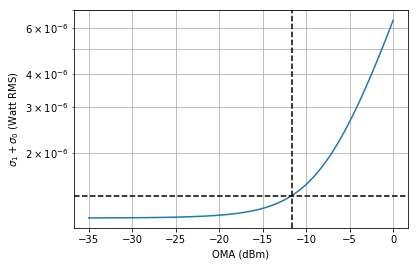

In [9]:
OMA =  np.linspace(-35,0,101) # OMA = I_1-I_0

sigma_1_sq = sigma_D**2 + sigma_Tx**2 + sigma_john**2 + \
             sigma_shot_factor**2*dbm_to_w(OMA) + sigma_rin_factor**2*dbm_to_w(OMA)**2
sigma_1 = np.sqrt(sigma_1_sq)
l = plt.semilogy(OMA,sigma_1 + sigma_0 ,'-')
#plt.legend((l1, l2), ('l1','l2'))
plt.xlabel('OMA (dBm)')
plt.ylabel('$\sigma_{1}+\sigma_{0}$ (Watt RMS)')
plt.axhline(y=[dbm_to_w(-11.66578080348318)/7.05**2], color='k', linestyle='--')
plt.axvline(x=[-11.66578080348318], color='k', linestyle='--')
plt.title('')
plt.grid(True, which ="both")
plt.show()

#### Operation point for BER $10^{-12}$

Using the assumption that the zero level is close to zero, one can use the definition of the Q factor in optical regime to pose a quadratic equation that will allow us to find the corresponding power level:

<img src="img/Q_factor.png">

Here I use Python's symbolic library (SymPy) to state and solve the equation for $I_1$. 

In [10]:
noise_eq = Eq((x/Q_target**2-sigma_0)**2,sigma_1_eq)
pprint(noise_eq)
a = solveset(noise_eq,x)
pprint(a)



                                            2                        2        
(0.0201197122881143⋅x - 4.52305296672551e-7)  = 3.16227766016838e-5⋅x  + 3.560

                                       
39249066667e-9⋅x + 4.54580081398044e-13
{-9.83104479985292e-6, 6.81431051509721e-5}


In [11]:
# The correct solution is obviously the one that represents a positive optical power
I_target = a.args[1] # Power for Q target in W
I_target_dBm = mw_to_dbm(I_target*1e3) # Power for Q target in dBm 
pprint(I_target_dBm)

-11.66578080348318


## Plots

####  Q Factor vs optical power with all sources of noise

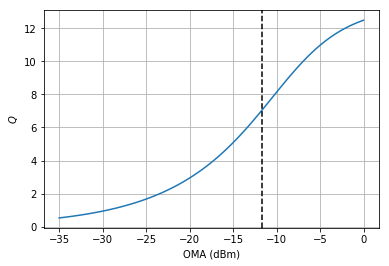

In [12]:
Q_vec = np.sqrt(dbm_to_w(OMA)/(sigma_1+sigma_0)) 
#Q_vec = dbm_to_w(OMA)/(sigma_1) 
SNR_dBm_vec = 10*np.log10(Q_vec**2)

l = plt.plot(OMA,Q_vec,'-')
#plt.legend((l1, l2), ('l1','l2'))
plt.axvline(x=[I_target_dBm], color='k', linestyle='--')
plt.xlabel('OMA (dBm)')
plt.ylabel('$Q$ ')
plt.title('')
plt.grid(True, which ="both")
plt.show()


#### SNR (dB) vs optical power at the receiver with all sources of noise

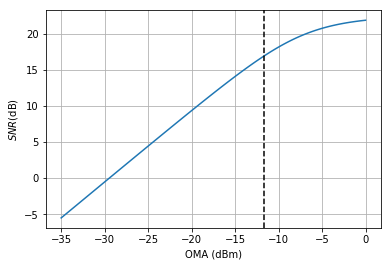

In [13]:
l = plt.plot(OMA,SNR_dBm_vec,'-')
#plt.legend((l1, l2), ('l1','l2'))
plt.axvline(x=[I_target_dBm], color='k', linestyle='--')
plt.xlabel('OMA (dBm)')
plt.ylabel('$SNR$(dB) ')
plt.title('')
plt.grid(True, which ="both")
plt.show()

# l = plt.plot(dbm_to_w(OMA)*1e3,Q_vec**2,'-')
# #plt.legend((l1, l2), ('l1','l2'))
# #plt.axvline(x=[I_target_dBm], color='k', linestyle='--')
# plt.xlabel('OMA (mW)')
# plt.ylabel('$SNR$ ')
# plt.title('')
# plt.grid(True, which ="both")
# plt.show()

#### $BER_Q$
Errors are detected after a decision has been made on wether the received signal belongs to symbol $I_1$ or $I_0$ and this decision is compared with the known transmitted signal. The decision of which symbol arrived is made by comparing with a reference treshold level $I^{th}$. Symbols $I_1$ and $I_0$ are sent with an equal rate, so the probability of detecting each is the same:
$$P(I_1) = P(I_0) = 1/2$$

An error in our example with binary signals is encountered when we decide $I_1$ when $I_0$ is transmitted or when we decide  $I_0$ when $I_1$ is transmitted.

The BER is given by the sum of the probabilities of these two events, each multiplied by the probability that the corresponding transmitted symbol was sent:

$$BER = P(I_1)P(I_0|I_1) + P(I_0)P(I_1|I_0)$$

In this expresion the probability that symbol $I_1$ is detected when $I_0$ is transmitted is denoted by $P(I_1|I_0)$.

If the symbols that arrive to the detector are affected by noise with a normal Gaussian distribution we can define the probability $P(I_1|I_0)$ in mathematical terms by using the statistics of the noise. 
The power level that we represented before as symbol $I_1$ is replaced by the mean ($\mu_1$) of the Gaussian distribution with standard deviation $\sigma_1$.

$$ P(I_0|I_1) = Q\left(\dfrac{\mu_1-I^{th}}{\sigma_1}\right) = \dfrac{1}{2}erfc\left( \dfrac{\mu_1-I^{th}}{\sigma_1\sqrt{2}}\right)$$

- $Q(x)$ is the Q-function from statistics. It is the same as $1-\Phi_X(x)$ where $\Phi_X(x)$ is the cummulative distribution function of the normal Gaussian Distribution.
- $erfc(x)$ is the [complementary error function](http://mathworld.wolfram.com/Erfc.html).

Similarly, 
$$ P(I_1|I_0) = Q\left(\dfrac{I^{th}-\mu_0}{\sigma_0}\right) = \dfrac{1}{2}erfc\left( \dfrac{I^{th}-\mu_0}{\sigma_0\sqrt{2}}\right)$$



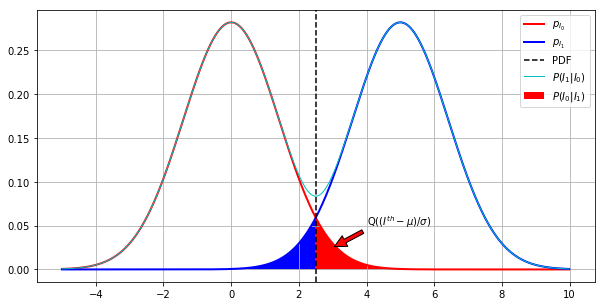

In [14]:
def make_gauss(N, sig, mu):
    return lambda x: N/(sig * (2*np.pi)**.5) * np.e ** (-(x-mu)**2/(2 * sig**2))

pylab.rcParams['figure.figsize'] = (10, 5)

ax = plt.figure().add_subplot(1,1,1)
plt.grid(True, which ="both")
x = np.arange(-5, 10, 0.01)
zero = np.zeros(len(x))
sig = np.sqrt(2)
mu = 0 
Ith = 2.5
Q_fac = (Ith-mu)/sig
gauss_mu0 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu0, 'r', linewidth=2)
ax.fill_between( x[(x>Ith)], zero[(x>Ith)],gauss_mu0[(x>Ith)],where=gauss_mu0[(x>Ith)] >= zero[(x>Ith)], facecolor='red', interpolate=True)

ax.annotate('Q($(I^{th}-\mu)/\sigma$)', xy=(3, 0.025), xytext=(4, 0.05),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )

mu = 5 

gauss_mu1 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu1, 'b', linewidth=2)
ax.fill_between( x[(x<Ith)], zero[(x<Ith)],gauss_mu1[(x<Ith)],where=gauss_mu1[(x<Ith)] >= zero[(x<Ith)], facecolor='blue', interpolate=True)
ax.axvline(x=Ith, color='k', linestyle='--')
ax.plot(x, np.sqrt(gauss_mu1**2+gauss_mu0**2), 'c', linewidth=1)
plt.legend(['$p_{I_0}$', '$p_{I_1}$', 'PDF','$P(I_1|I_0)$', '$P(I_0|I_1)$'], loc='best')
plt.savefig("PAM2_PDF.svg", bbox_inches=0, transparent=True)
plt.show()


And the optimum decision treshold can be computed from both signals statistical moments using:

$$\dfrac{(I^{th}-\mu_0)^2}{2\sigma_0^2} = \dfrac{(\mu_1-I^{th})^2}{2\sigma_1^2}+\ln{\dfrac{\sigma_1}{\sigma_0}}$$

 $$I^{th}= \dfrac{\mu_0\sigma_1^2-\mu_1\sigma_0^2 + \sigma_1\sigma_0\sqrt{(\mu_1-\mu_0)^2+2(\sigma_1^2+\sigma_0^2)\ln{\sigma_1/\sigma_0}}}{\sigma_1^2-\sigma_0^2}$$ 

If we consider the $\ln$ to be negligible then:
$$I^{th}= \dfrac{\sigma_0\mu_1+\sigma_1\mu_0}{\sigma_1+\sigma_0}$$ 
So that:
$$\dfrac{\mu_1-I^{th}}{\sigma_1}=\dfrac{I^{th}-\mu_0}{\sigma_0}= \dfrac{\mu_1-\mu_0}{\sigma_1+\sigma_0}= Q_{fac}$$ 
And
$$BER_Q = \dfrac{1}{2}erfc\left(\dfrac{Q_{fac}}{\sqrt{2}}\right) $$

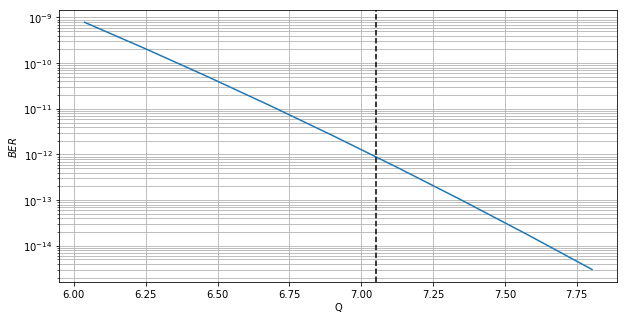

In [15]:
BER_Q = lambda Q: 1/2*erfc(Q/np.sqrt(2))
Q_BER = lambda BER: np.sqrt(2)*erfcinv(2*BER)

plt.figure()
l = plt.semilogy(Q_vec[(Q_vec>6)&(Q_vec<8)],BER_Q(Q_vec[(Q_vec>6)&(Q_vec<8)]),'-')
plt.axvline(x=[Q_target], color='k', linestyle='--')
#plt.legend((l1, l2), ('l1','l2'))
plt.xlabel('Q')
plt.ylabel('$BER$ ')
plt.title('')
plt.grid(True, which ="both")
#plt.xlim(6, 8)
pylab.rcParams['figure.figsize'] = (8, 5)
plt.show()


## Other analysis

Now that I have proved that the implementation returns the expected result, I can start playing with the values.

Things that would be interesting to try later:
- Input parameters that are closer to our application:
    - Our dark current estimate
    - Our RIN estimate
    - Our Bandwidth: 56 GHz
    - Our Tia conversion factor
- Make surface plots that show how the Q factor evolves as a function of more than one parameter.
- Try to implement an equivalent Q factor for PAM-4 signals.
- Think how does coherent detection behaves in comparison.
- How does SNR deviate from Q factor when the modulation changes?

#### BER for PAM-4  

As the number of levels increases the definition of BER needs to take into account wrong counting of symbols for all treshold levels.

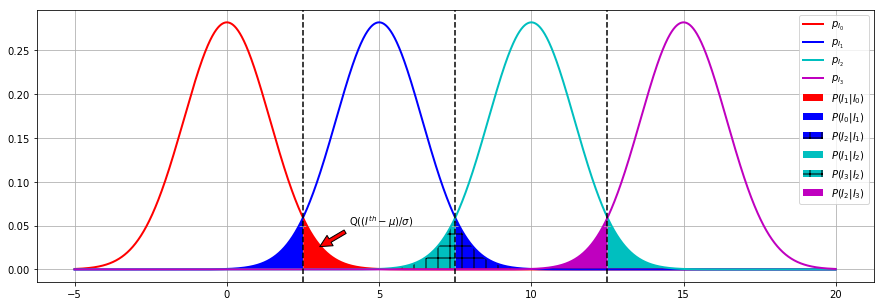

In [19]:
ax = plt.figure().add_subplot(1,1,1)
pylab.rcParams['figure.figsize'] = (15, 5)
plt.grid(True, which ="both")
x = np.arange(-5, 20, 0.01)
zero = np.zeros(len(x))
sig = np.sqrt(2)
mu = 0 
Ith = 2.5
Ith1 = 7.5
Ith2 = 12.5


Q_fac = (Ith-mu)/sig
gauss_mu0 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu0, 'r', linewidth=2)
ax.fill_between( x[(x>Ith)], zero[(x>Ith)],gauss_mu0[(x>Ith)],where=gauss_mu0[(x>Ith)] >= zero[(x>Ith)], facecolor='red', interpolate=True)

ax.annotate('Q($(I^{th}-\mu)/\sigma$)', xy=(3, 0.025), xytext=(4, 0.05),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )

mu = 5 

gauss_mu1 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu1, 'b', linewidth=2)
ax.fill_between( x[(x<Ith)], zero[(x<Ith)],gauss_mu1[(x<Ith)],where=gauss_mu1[(x<Ith)] >= zero[(x<Ith)], facecolor='blue', interpolate=True)
ax.fill_between( x[(x>Ith1)], zero[(x>Ith1)],gauss_mu1[(x>Ith1)],where=gauss_mu1[(x>Ith1)] >= zero[(x>Ith1)], facecolor='b',hatch='+', interpolate=True)
mu = 10

gauss_mu2 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu2, 'c', linewidth=2)
ax.fill_between( x[(x>Ith2)], zero[(x>Ith2)],gauss_mu2[(x>Ith2)],where=gauss_mu2[(x>Ith2)] >= zero[(x>Ith2)], facecolor='c', interpolate=True)
ax.fill_between( x[(x<Ith1)], zero[(x<Ith1)],gauss_mu2[(x<Ith1)],where=gauss_mu2[(x<Ith1)] >= zero[(x<Ith1)], facecolor='c',hatch='+', interpolate=True)

mu = 15

gauss_mu3 = make_gauss(1, sig, mu)(x)
ax.plot(x, gauss_mu3, 'm', linewidth=2)
ax.fill_between( x[(x<Ith2)], zero[(x<Ith2)],gauss_mu3[(x<Ith2)],where=gauss_mu3[(x<Ith2)] >= zero[(x<Ith2)], facecolor='m', interpolate=True)


#ax.plot(x, np.sqrt(gauss_mu1**2+gauss_mu0**2+gauss_mu2**2+gauss_mu3**2), 'b', linewidth=1)
plt.legend(['$p_{I_0}$', '$p_{I_1}$','$p_{I_2}$', '$p_{I_3}$', '$P(I_1|I_0)$', '$P(I_0|I_1)$', '$P(I_2|I_1)$', '$P(I_1|I_2)$', '$P(I_3|I_2)$', '$P(I_2|I_3)$'], loc='best')
ax.axvline(x=Ith, color='k', linestyle='--')
ax.axvline(x=Ith1, color='k', linestyle='--')
ax.axvline(x=Ith2, color='k', linestyle='--')
plt.savefig("PAM4_PDF.svg", bbox_inches=0, transparent=True)
plt.show()

One symbol error in PAM-N modulation formats causes log2(N) bit errors:
\begin{equation*}
BER_{target} = \dfrac{1}{\log_2{(N)}}SER_{target}.
\end{equation*}
We want to find the symbol error rate first
\begin{equation*}
SER_{target} =\sum_{i=1}^{N}P(I_i)
              \left(P(I_{i-1}|I_i)+P(I_{i+1}|I_i)\right)
\end{equation*}
Assuming gaussian distribution of noise with equal $\sigma$ for all levels, and assuming that the SNR is sufficiently high so that only the probability of error to first neighbours is considered: 
\begin{multline}
SER_{target} =
			\dfrac{1}{4}Q\left( \dfrac{I^{th1}-\mu_0}{\sigma_{ideal}}  \right)+
				\dfrac{1}{4}\left[ Q\left( \dfrac{\mu_1-I^{th1}}{\sigma_{ideal}}\right)+
				                   Q\left( \dfrac{I^{th2}-\mu_1}{\sigma_{ideal}}\right)
									\right] +  \\ 
				\dfrac{1}{4}\left[ Q\left( \dfrac{\mu_2-I^{th2}}{\sigma_{ideal}}\right)+
				                   Q\left( \dfrac{I^{th3}-\mu_2}{\sigma_{ideal}}\right)
									\right]  +
				\dfrac{1}{4}Q\left( \dfrac{\mu_3-I^{th3}}{\sigma_{ideal}}\right).
\end{multline}

The means can be described in terms of the OMA so that $\mu_i =i\cdot\dfrac{OMA}{3}$. This is of course assuming that  $\mu_0\approx 0$. The tresholds are defined in IEEE P802.3bs as follows:

- $I^{th1} = P_{ave} -\dfrac{OMA}{3}$
- $I^{th2} = P_{ave} =\dfrac{OMA}{2}$
- $I^{th3} = P_{ave} -\dfrac{OMA}{3}$

Such a definition allows us to arrieve to the simplified expresion:

$$SER_{target} =\dfrac{2}{3}Q\left(\dfrac{OMA}{6\cdot\sigma_{ideal}}\right)=\dfrac{2}{3}Q\left(\dfrac{1}{3}SNR\right)$$
Or the one used in TDECQ calculations for extracting the ideal noise:
$$\sigma_{ideal} =\dfrac{OMA}{6\cdot Q^{^-1}\left(\dfrac{2}{3}SER_{target}\right)}$$

1.60167751043865e-6
21.2724174207547
13.278168464066127


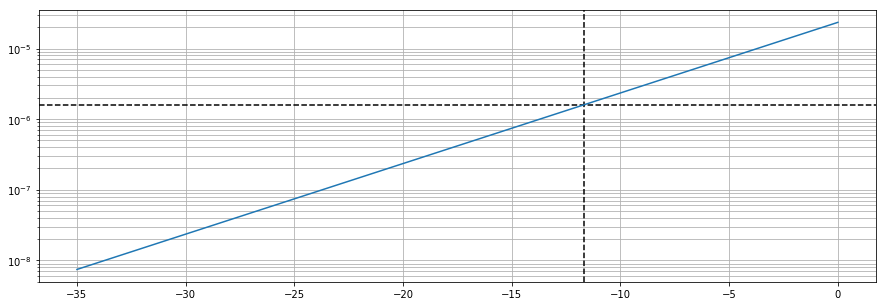

In [20]:
SER_target = 1e-12
sigma_ideal = dbm_to_w(OMA)/(6*Q_BER(2/3*SER_target))
plt.axvline(x=[I_target_dBm], color='k', linestyle='--')
plt.axhline(y=[dbm_to_w(I_target_dBm)/(6*Q_BER(2/3*SER_target))], color='k', linestyle='--')
plt.semilogy(OMA,sigma_ideal)
plt.grid(True, which ="both")
sigma_at_I_target_PAM4 = I_target/(6*Q_BER(2/3*SER_target))
print(sigma_at_I_target_PAM4)
SNR_PAM4 = (I_target/2)/sigma_at_I_target_PAM4
print(SNR_PAM4)
print(10*log10(SNR_PAM4))

#### How does it compare with PAM-2


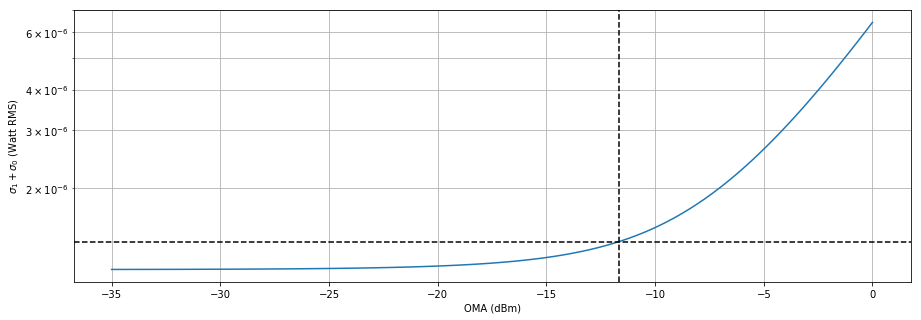

1.37101967005628e-6
49.7025000000000
16.963782339827976


In [21]:
OMA =  np.linspace(-35,0,101) # OMA = I_1-I_0

sigma_1_sq = sigma_D**2 + sigma_Tx**2 + sigma_john**2 + \
             sigma_shot_factor**2*dbm_to_w(OMA) + sigma_rin_factor**2*dbm_to_w(OMA)**2
sigma_1 = np.sqrt(sigma_1_sq)
l = plt.semilogy(OMA,sigma_1 + sigma_0 ,'-')
#plt.legend((l1, l2), ('l1','l2'))
plt.xlabel('OMA (dBm)')
plt.ylabel('$\sigma_{1}+\sigma_{0}$ (Watt RMS)')
plt.axhline(y=[dbm_to_w(-11.66578080348318)/7.05**2], color='k', linestyle='--')
plt.axvline(x=[-11.66578080348318], color='k', linestyle='--')
plt.title('')
plt.grid(True, which ="both")
plt.show()
sigma_at_I_target=I_target/7.05**2
print(sigma_at_I_target)
SNR = I_target/sigma_at_I_target
print(SNR)
print(10*log10(SNR))

In [22]:
 10*log10(SNR)-10*log10(SNR_PAM4) 


3.685613875761849

## TDECQ
- $\sigma_{ideal}$: Maximum noise tolerable to be below target BER.
- $\sigma_{real}$: Maximum noise tolerable in real system, using all tricks before reaching BER target
$$TDECQ= 10\cdot\log_{10}\left(\dfrac{\sigma_{ideal}}{\sigma_{real}} \right) $$

In [24]:
BER_Q(3.414)

0.00032008287885049007

-4.771212547196624